<a href="https://colab.research.google.com/github/Tavo826/Growing-neuronal-cellular-automata/blob/main/AutomataCelular_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
POOL_SIZE = 1024
N_CHANNEL = 16
BATCH_SIZE = 8
width = height = int(math.sqrt(POOL_SIZE))

#device = torch.device('cpu')
#device = torch.device('cuda:0')
plt.ion()
plt.show()
torch.cuda.is_available()

True

In [ ]:
#Filtros de precepción: identidad y gradiantes X,Y
sobelX = torch.from_numpy(np.array([[-1,0,1], \
                                    [-2,0,2], \
                                    [-1,0,1]]).astype(float)).repeat((N_CHANNEL,1,1,1))#.to(device)
sobelY = torch.from_numpy(np.array([[-1,-2,-1], \
                                    [0,0,0], \
                                    [1,2,1]]).astype(float)).repeat((N_CHANNEL,1,1,1))#.to(device_name)
cellId = torch.from_numpy(np.array([[0,0,0], \
                                    [0,0,0], \
                                    [0,0,0]]).astype(float)).repeat((N_CHANNEL,1,1,1))#.to(device_name)

filters = [sobelX, sobelY, cellId]

def imshowTensor(x, chan_n=3):
    plt.imshow(x[0,:chan_n,...].detach().numpy().transpose(1,2,0))
    plt.show()
    return

RuntimeError: ignored

In [ ]:
class UpdateGrid(nn.Module):

    def __init__(self):
        super(UpdateGrid, self).__init__()

        self.fc1 = nn.Conv2d(N_CHANNEL * len(filters), 128, (1,1))        
        self.fc2 = nn.Conv2d(128, N_CHANNEL, (1,1))
        nn.init.zeros_(self.fc2.weight)

    def forward(self, x):       

        #Se crea un tensor para guardar la computación de los filtros
        perception = torch.empty((BATCH_SIZE, len(filters) * N_CHANNEL, width, height))#.to(device)
        
        #Se calculan los vectores de percepción con cada filtro. 
        #3 filtros x 16 = 48 componentes
        for f,filt in enumerate(filters):

            perception[:, (f*N_CHANNEL):((f+1)*N_CHANNEL),:,:] = F.conv2d(x, 
            filt, padding=[1,1], groups=N_CHANNEL)

        #Red neuronal
        dx = self.fc1(perception)
        dx = F.relu(dx)
        dx = self.fc2(dx)

        #Skip connection + sctochastic update
        #Cada célula tiene un 50% de ser actualizada
        randomMask = torch.from_numpy(np.random.randint(0, 2, (BATCH_SIZE, 1, width, height))).repeat(1,16,1,1)#.to(device)
        x = x + dx * randomMask

        #Se limita el crecimiento de las células vivas
        alv_f = torch.from_numpy(np.ones((1,1,3,3)).astype(int))#.to(device)
        alive = F.conv2d((x[:,3:4,:,:] > 0.1).double(),
            alv_f.double(), padding=1)

        alive = (alive > 0.0)
        alive = alive.repeat(1,16,1,1)

        return x * alive

In [ ]:
#Se instancia el modelo
updateGrid = UpdateGrid()#.to(device)

#Se carga la imagen objetivo
target = torch.tensor(np.array(Image.open('/content/drive/My Drive/Colab Notebooks/100HorasML/Growing neural cellular automata/im_noFondo_pq.png')) / 255)#.to(device)

#Se declara la función de error
loss_f = nn.MSELoss()

#Creando el optimizador
optimizer = optim.Adam(updateGrid.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=500, gamma=0.1)


for p in updateGrid.parameters():
    p.register_hook(lambda grad: grad / (torch.norm(grad,2) + 1e-8))

save_path = '/content/drive/My Drive/Colab Notebooks/100HorasML/Growing neural cellular automata/models'
save_steps = 250

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:127: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  allow_unreachable=True)  # allow_unreachable flag


TrLoss 0:0.2701; lr= 0.001
TrLoss 1:0.2102; lr= 0.001
TrLoss 2:0.2036; lr= 0.001
TrLoss 3:0.2039; lr= 0.001
TrLoss 4:0.2021; lr= 0.001
TrLoss 5:0.1970; lr= 0.001
TrLoss 6:0.1926; lr= 0.001
TrLoss 7:0.1559; lr= 0.001
TrLoss 8:0.0946; lr= 0.001
TrLoss 9:0.0869; lr= 0.001
TrLoss 10:0.0869; lr= 0.001
TrLoss 11:0.0869; lr= 0.001
TrLoss 12:0.0869; lr= 0.001
TrLoss 13:0.0869; lr= 0.001
TrLoss 14:0.0869; lr= 0.001
TrLoss 15:0.0869; lr= 0.001
TrLoss 16:0.0869; lr= 0.001
TrLoss 17:0.0869; lr= 0.001
TrLoss 18:0.0869; lr= 0.001
TrLoss 19:0.0869; lr= 0.001
TrLoss 20:0.0869; lr= 0.001
TrLoss 21:0.0869; lr= 0.001
TrLoss 22:0.0869; lr= 0.001
TrLoss 23:0.0869; lr= 0.001
TrLoss 24:0.0869; lr= 0.001
TrLoss 25:0.0869; lr= 0.001
TrLoss 26:0.0869; lr= 0.001
TrLoss 27:0.0869; lr= 0.001
TrLoss 28:0.0869; lr= 0.001
TrLoss 29:0.0869; lr= 0.001
TrLoss 30:0.0869; lr= 0.001
TrLoss 31:0.0869; lr= 0.001
TrLoss 32:0.0869; lr= 0.001
TrLoss 33:0.0869; lr= 0.001
TrLoss 34:0.0869; lr= 0.001
TrLoss 35:0.0869; lr= 0.001
Tr

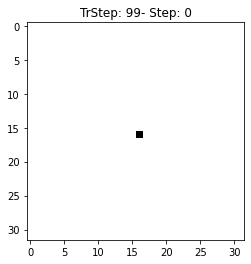

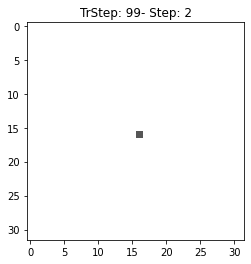

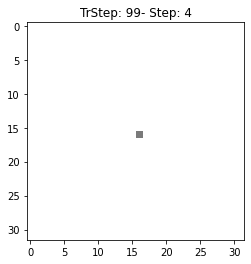

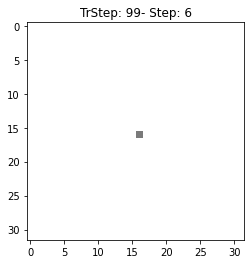

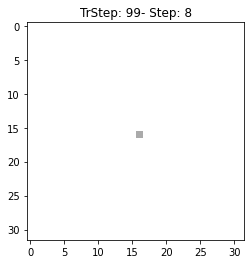

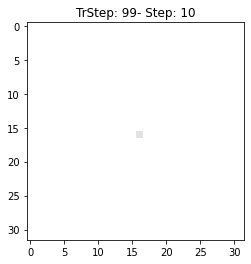

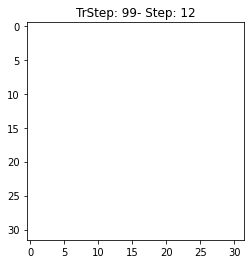

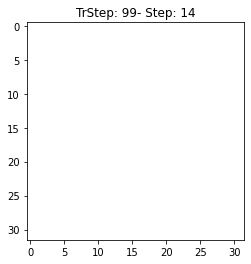

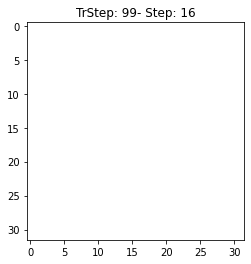

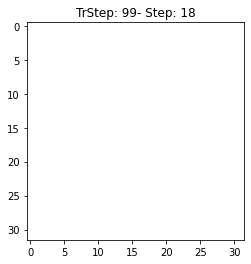

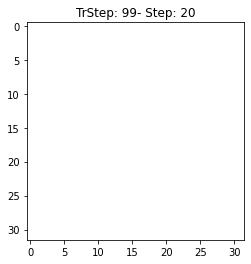

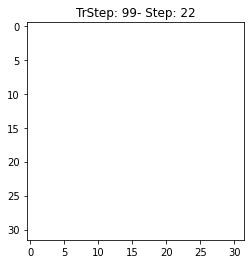

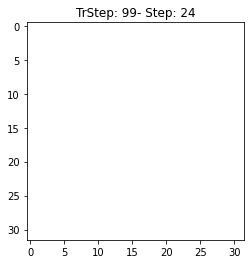

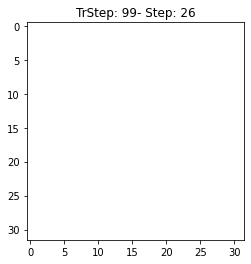

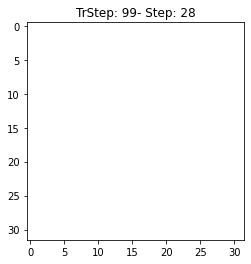

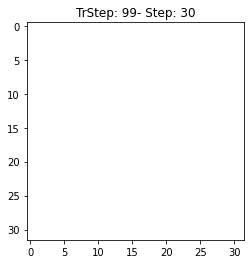

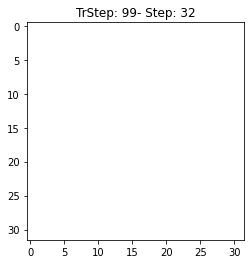

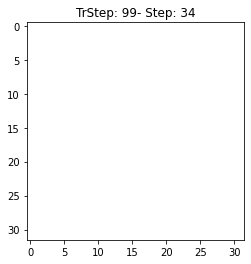

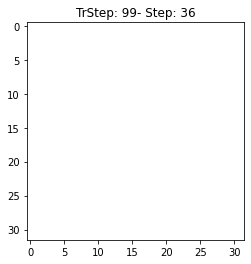

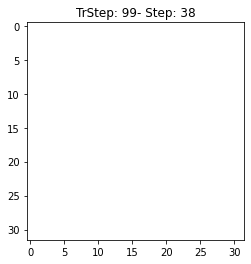

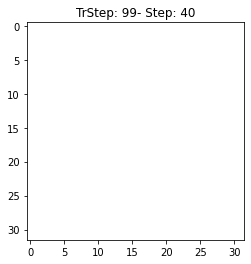

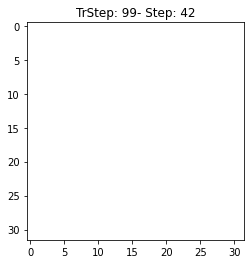

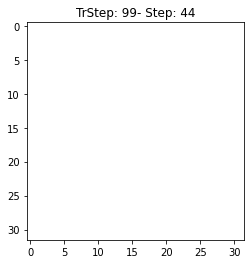

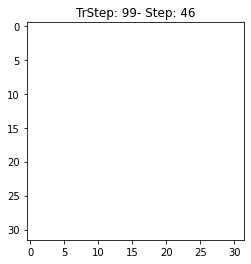

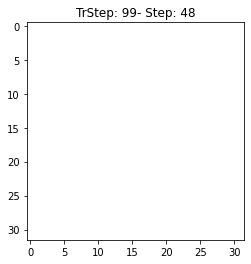

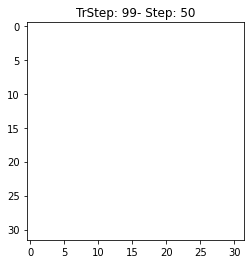

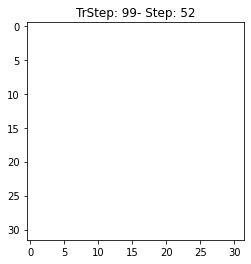

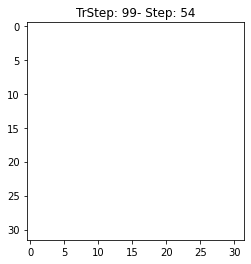

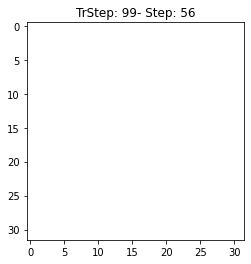

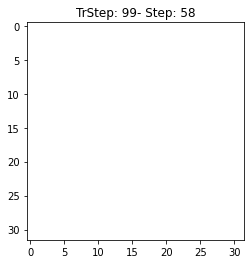

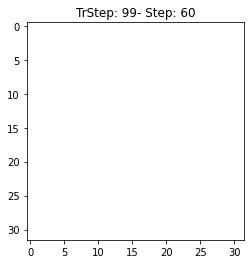

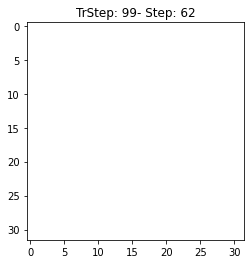

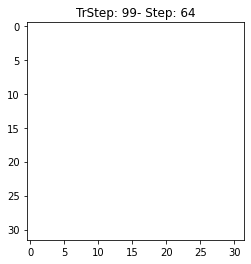

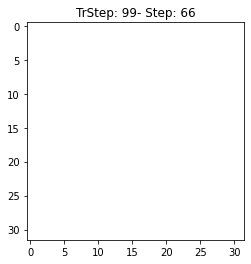

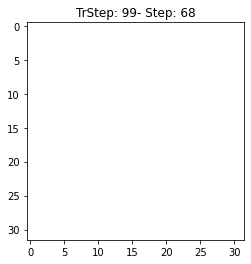

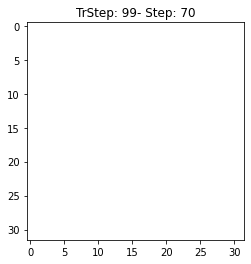

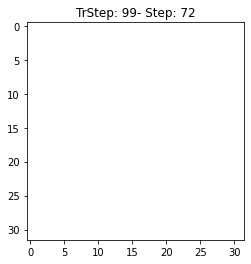

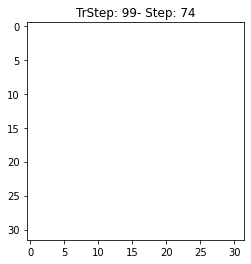

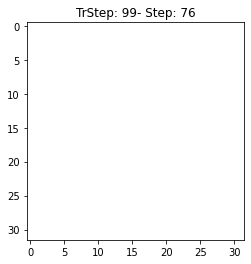

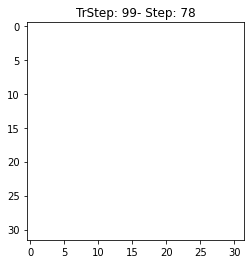

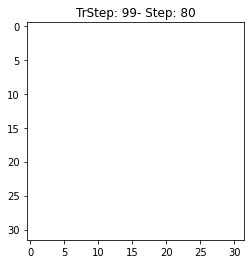

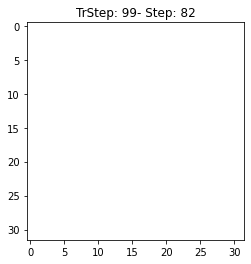

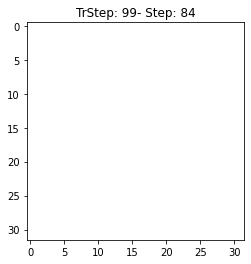

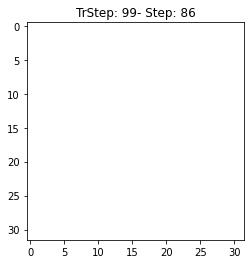

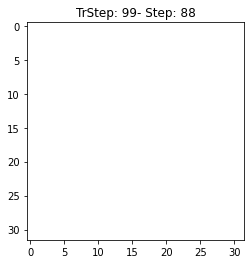

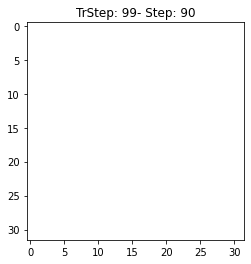

TrLoss 99:0.0869; lr= 0.001
TrLoss 100:0.0869; lr= 0.001
TrLoss 101:0.0869; lr= 0.001
TrLoss 102:0.0869; lr= 0.001
TrLoss 103:0.0869; lr= 0.001
TrLoss 104:0.0869; lr= 0.001
TrLoss 105:0.0869; lr= 0.001
TrLoss 106:0.0869; lr= 0.001
TrLoss 107:0.0869; lr= 0.001
TrLoss 108:0.0869; lr= 0.001
TrLoss 109:0.0869; lr= 0.001
TrLoss 110:0.0869; lr= 0.001
TrLoss 111:0.0869; lr= 0.001
TrLoss 112:0.0869; lr= 0.001
TrLoss 113:0.0869; lr= 0.001
TrLoss 114:0.0869; lr= 0.001
TrLoss 115:0.0869; lr= 0.001
TrLoss 116:0.0869; lr= 0.001
TrLoss 117:0.0869; lr= 0.001
TrLoss 118:0.0869; lr= 0.001
TrLoss 119:0.0869; lr= 0.001
TrLoss 120:0.0869; lr= 0.001
TrLoss 121:0.0869; lr= 0.001
TrLoss 122:0.0869; lr= 0.001
TrLoss 123:0.0869; lr= 0.001
TrLoss 124:0.0869; lr= 0.001
TrLoss 125:0.0869; lr= 0.001
TrLoss 126:0.0869; lr= 0.001
TrLoss 127:0.0869; lr= 0.001
TrLoss 128:0.0869; lr= 0.001
TrLoss 129:0.0869; lr= 0.001
TrLoss 130:0.0869; lr= 0.001
TrLoss 131:0.0869; lr= 0.001
TrLoss 132:0.0869; lr= 0.001
TrLoss 133:0.08

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
n_epochs = 500

#Mostrar imagen cada...
debug_img = 100

for trStep in range(n_epochs + 1):

    #Se selecciona un número aleatorio de steps
    n_steps = np.random.randint(64,96)

    #Se inicializa la rejilla vacía
    grid = np.zeros((width, height, N_CHANNEL))
    #Se añade la célula viva en medio
    grid[height // 2, width // 2 ,3:] = 1.0
    
    batch_grid = np.repeat(grid[np.newaxis, ...], BATCH_SIZE, axis=0)

    #Se crea un tensor resultado donde se guarda la computación
    result = torch.from_numpy(batch_grid).permute(0,3,1,2)#.to(device)

    for step in range(n_steps):

        #Se confirma que ninguna célula sobrepase el rango 0-1
        result = torch.clamp(updateGrid.forward(result), 0.0, 1.0)

        if (trStep+1) % debug_img == 0 and step % 2 == 0:
            
            batch_img = result[0,:4,:,:].detach().cpu().numpy()
            
            imRes = np.clip(batch_img.transpose(1,2,0)[:,:,:4], 0.0, 1.0)
            plt.imshow(imRes)
            
            plt.title('TrStep: ' + str(trStep) + '- Step: ' + str(step))
            plt.draw()
            #ax.set_facecolor('white')
            plt.pause(0.001)
            plt.clf()
            #plt.imsave('./Output_imgs/img_' + str(trStep) + '_' + str(step) + '.png', imRes)
            #plt.show()

    #Se limpia el gradiente
    optimizer.zero_grad()

    resutl = torch.clamp(result, 0.0, 1.0)

    #Se extrae la componente RGBA de la célula
    output = result[:,:4,:,:].permute(0,2,3,1)
    #Se calcula el error cuadrático medio de la imagen resultante y la objetivo
    loss = loss_f(output, target.repeat((BATCH_SIZE,1,1,1)))
    #Se optimiza en base a este error
    loss.backward()
    #Se optimiza un paso
    optimizer.step()
    scheduler.step()

    if (trStep+1) % save_steps == 0:
      torch.save(updateGrid.state_dict(), save_path + '_' + str(trStep) + '.pth')

    print('TrLoss ' + str(trStep) + ':' + str(loss.item())[0:6] + '; lr= ' + str(optimizer.param_groups[0]['lr']))